In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
def create_graph_data(df, node_list):
    # Create a mapping of node names to indices
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Convert edges to indices
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T  # Transpose to get the shape [2, num_edges]

    # Node features (converted to numpy array or tensor)
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)

    # Labels (0 for non-fraud, 1 for fraud)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)

    return node_features, edge_index, labels


In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [7]:
# Plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

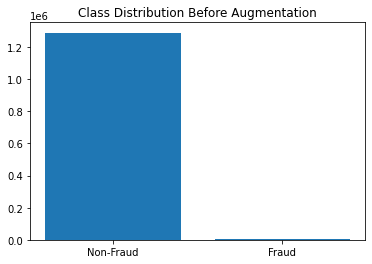

In [8]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation")

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

def create_adjacency_matrix(df, node_list):
    # Step 1: Create a mapping from node to index
    node_map = {node: idx for idx, node in enumerate(node_list)}

    # Step 2: Initialize an empty adjacency matrix of size [num_nodes, num_nodes]
    num_nodes = len(node_list)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    # Step 3: Iterate over each row in the dataframe and update the adjacency matrix
    for from_node, to_node in zip(df['node_from'], df['node_to']):
        from_idx = node_map[from_node]
        to_idx = node_map[to_node]
        adjacency_matrix[from_idx, to_idx] = 1  # Directed edge from from_node to to_node

    return adjacency_matrix

adjacency_matrix = create_adjacency_matrix(df, node_list)

# Step 1: Define a GCN layer
class GCNLayer(layers.Layer):
    def __init__(self, output_dim, activation=None):
        super(GCNLayer, self).__init__()
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, node_features, adjacency_matrix):
        # GCN operation: A * X * W (adjacency matrix times node features times weights)
        support = tf.matmul(node_features, self.kernel)
        output = tf.matmul(adjacency_matrix, support)
        if self.activation:
            output = self.activation(output)
        return output

In [10]:
# Updated WGAN Generator with GCN Layers
class WGANGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, gcn_hidden_size):
        super(WGANGenerator, self).__init__()
        self.gcn1 = GCNLayer(input_size, gcn_hidden_size, activation=F.relu)
        self.gcn2 = GCNLayer(gcn_hidden_size, hidden_size, activation=F.relu)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, z, adjacency_matrix):
        z = self.gcn1(z, adjacency_matrix)
        z = self.gcn2(z, adjacency_matrix)
        return torch.tanh(self.fc(z))  # Final activation as per generator requirements

In [11]:
# Updated WGAN Discriminator with GCN Layers
class WGANDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size, gcn_hidden_size):
        super(WGANDiscriminator, self).__init__()
        self.gcn1 = GCNLayer(input_size, gcn_hidden_size, activation=F.relu)
        self.gcn2 = GCNLayer(gcn_hidden_size, hidden_size, activation=F.relu)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, adjacency_matrix):
        x = self.gcn1(x, adjacency_matrix)
        x = self.gcn2(x, adjacency_matrix)
        return self.fc(x)  # Output raw score without activation (WGAN uses raw score)


In [10]:
# WGAN parameters
input_size = node_features.shape[1]
hidden_size = 128
output_size = input_size
latent_size = 64
gcn_hidden_size = 64

In [13]:
# Initialize WGAN components
generator = WGANGenerator(latent_size, hidden_size, output_size, gcn_hidden_size)
discriminator = WGANDiscriminator(input_size, hidden_size, gcn_hidden_size)

In [14]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)

In [15]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [16]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(node_features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([2.3957e-03, 6.2278e+00, 4.4526e+02, 2.6677e+01]), Initial Variance: tensor([3.0670e-05, 1.5315e+01, 6.6874e+04, 2.0538e+02]), Initial Std Dev: tensor([5.5381e-03, 3.9134e+00, 2.5860e+02, 1.4331e+01])


In [17]:
# Training with early stopping
num_epochs = 16
target_minority_class = torch.sum(labels == 0)
real_data = node_features[labels == 1]

In [18]:
# Early stopping parameters
best_loss_d = float('inf')
patience = 1
trigger_times = 0

In [19]:
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Update the discriminator 5 times for every generator update
    for _ in range(5):
        z = torch.randn(real_data.size(0), latent_size)
        fake_data = generator(z)

        optimizer_d.zero_grad()
        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data.detach())
        loss_d = -torch.mean(d_real) + torch.mean(d_fake)
        loss_d.backward()
        optimizer_d.step()

        # Clip weights
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    optimizer_g.zero_grad()
    fake_data = generator(torch.randn(real_data.size(0), latent_size))
    loss_g = -torch.mean(discriminator(fake_data))
    loss_g.backward()
    optimizer_g.step()

    # Update labels based on newly generated samples
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    node_features = torch.cat((node_features, fake_data))

    # Early stopping check
    if loss_d.item() < best_loss_d:
        best_loss_d = loss_d.item()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping triggered")
        break

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')


Epoch [0/16], Loss D: -0.35834982991218567, Loss G: -0.010147985070943832
Epoch [1/16], Loss D: -0.4399767816066742, Loss G: -0.01005773525685072
Epoch [2/16], Loss D: -0.513852059841156, Loss G: -0.009975356981158257
Epoch [3/16], Loss D: -0.5846003890037537, Loss G: -0.009895249269902706
Epoch [4/16], Loss D: -0.6532214879989624, Loss G: -0.009819505736231804
Epoch [5/16], Loss D: -0.7208928465843201, Loss G: -0.009736592881381512
Epoch [6/16], Loss D: -0.7878419756889343, Loss G: -0.00966282095760107
Epoch [7/16], Loss D: -0.853810727596283, Loss G: -0.00959080457687378
Epoch [8/16], Loss D: -0.9187986254692078, Loss G: -0.009519949555397034
Epoch [9/16], Loss D: -0.9831116199493408, Loss G: -0.00948223378509283
Epoch [10/16], Loss D: -1.0467662811279297, Loss G: -0.009392029605805874
Epoch [11/16], Loss D: -1.1098198890686035, Loss G: -0.009347864426672459
Epoch [12/16], Loss D: -1.1716290712356567, Loss G: -0.00928428303450346
Epoch [13/16], Loss D: -1.2311666011810303, Loss G: -0

In [20]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))
y_generated = torch.ones(num_generated_samples, dtype=torch.long)

In [21]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

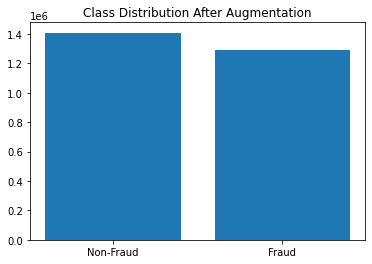

In [22]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation")

In [23]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

Final Mean: tensor([-1.6623e-01,  3.0168e+00,  2.1398e+02,  1.2811e+01],
       grad_fn=<MeanBackward1>), Final Variance: tensor([4.5227e-02, 1.6916e+01, 8.1619e+04, 2.7657e+02],
       grad_fn=<VarBackward0>), Final Std Dev: tensor([2.1267e-01, 4.1129e+00, 2.8569e+02, 1.6630e+01],
       grad_fn=<StdBackward0>)


In [24]:
# Assuming real_data is your actual node features labeled as fraud (real minority class)
real_data = node_features[labels == 1]  # Take only fraud samples (minority class)

# If generated_data has more samples than real_data, we need to match their size
min_size = min(real_data.size(0), generated_data.size(0))

# Subsample real and generated data to have the same number of rows
real_data_sampled = real_data[:min_size]
generated_data_sampled = generated_data[:min_size]

# Function to compute R-squared
def r_squared(real_data, generated_data):
    ss_res = torch.sum((real_data - generated_data) ** 2, dim=0)  # Residual sum of squares
    ss_tot = torch.sum((real_data - torch.mean(real_data, dim=0)) ** 2, dim=0)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [25]:
# Compute R-squared between the real and generated data samples
r2_scores = r_squared(real_data_sampled, generated_data_sampled)
print(f"R-squared for each feature: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean()}")

R-squared for each feature: tensor([-825.4730,   -3.6629,   -2.8834,   -3.5866], grad_fn=<RsubBackward1>)
Mean R-squared: -208.90147399902344


In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
# Function to calculate MCC
def calculate_mcc(y_true, y_pred):
    # Convert PyTorch tensors to NumPy arrays after detaching from the graph
    y_true_np = y_true.detach().cpu().numpy()  # Detach and move to CPU if necessary
    y_pred_np = y_pred.detach().cpu().numpy()  # Detach and move to CPU if necessary

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()

    # Convert confusion matrix components to PyTorch tensors
    tp = torch.tensor(tp, dtype=torch.float)
    tn = torch.tensor(tn, dtype=torch.float)
    fp = torch.tensor(fp, dtype=torch.float)
    fn = torch.tensor(fn, dtype=torch.float)

    # Apply MCC formula
    numerator = (tp * tn) - (fp * fn)
    denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    if denominator == 0:
        return 0  # Handle division by zero
    else:
        mcc = numerator / denominator
        return mcc

In [28]:
# Let's assume you have binary predictions from the discriminator
real_data_labels = labels  # Known 'is_fraud' labels (0 or 1)
generated_labels = torch.round(discriminator(generated_data_sampled)).detach()  # Detach here as well

In [29]:
# Ensure both real and generated labels have the same size
real_data_labels_sampled = real_data_labels[:min_size]

In [30]:
# Calculate MCC
mcc = calculate_mcc(real_data_labels_sampled, generated_labels)
print(f"Matthews Correlation Coefficient (MCC): {mcc}")

Matthews Correlation Coefficient (MCC): 0.7895396101


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Convert PyTorch tensors to NumPy arrays after detaching from the graph
    y_true_np = y_true.detach().cpu().numpy()  # Detach and move to CPU if necessary
    y_pred_np = y_pred.detach().cpu().numpy()  # Detach and move to CPU if necessary
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np)
    recall = recall_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np)
    
    return accuracy, precision, recall, f1

# Calculate metrics for the real and generated data labels
accuracy, precision, recall, f1 = calculate_metrics(real_data_labels_sampled, generated_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9947
Precision: 0.9544
Recall: 0.9568
F1 Score: 0.9595


/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Split Data into Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.2, random_state=42)

In [8]:
# Define Classifier Model
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [11]:
# Training Classifier on Balanced Dataset
classifier = Classifier(input_size, hidden_size)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [12]:
from sklearn.metrics import accuracy_score
import torch

# Classifier Training Loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(30):
    # Training phase
    classifier.train()
    optimizer.zero_grad()
    
    # Forward pass and backpropagation
    y_pred = classifier(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Detach loss for recording and release computation graph
    train_losses.append(loss.item())
    
    # Switch to evaluation mode for accuracy calculation
    classifier.eval()
    with torch.no_grad():
        # Training accuracy
        y_pred_train = classifier(x_train)
        train_accuracy = accuracy_score(y_train.cpu().numpy(), y_pred_train.argmax(dim=1).cpu().numpy())
        train_accuracies.append(train_accuracy)
        
        # Testing loss and accuracy
        y_test_pred = classifier(x_test)
        test_loss = loss_fn(y_test_pred, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred.argmax(dim=1).cpu().numpy())
        test_accuracies.append(test_accuracy)
    
    # Print stats every 5 epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')


Epoch 0, Train Loss: 2.6018, Test Loss: 0.4885, Train Acc: 0.8453, Test Acc: 0.8450
Epoch 5, Train Loss: 0.2600, Test Loss: 0.2711, Train Acc: 0.9942, Test Acc: 0.9943
Epoch 10, Train Loss: 0.3480, Test Loss: 0.3502, Train Acc: 0.9942, Test Acc: 0.9943
Epoch 15, Train Loss: 0.3975, Test Loss: 0.3920, Train Acc: 0.9942, Test Acc: 0.9943
Epoch 20, Train Loss: 0.4201, Test Loss: 0.4100, Train Acc: 0.9942, Test Acc: 0.9943
Epoch 25, Train Loss: 0.4257, Test Loss: 0.4130, Train Acc: 0.9942, Test Acc: 0.9943


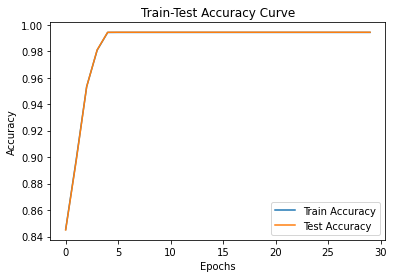

In [13]:
# Plot Train-Test Accuracy Curve
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train-Test Accuracy Curve")
plt.show()

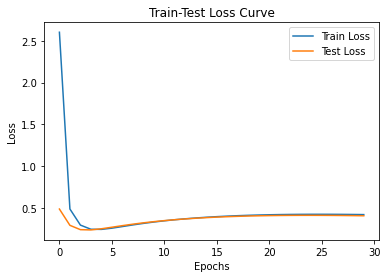

In [14]:
# Plot Train-Test Loss Curve
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train-Test Loss Curve")
plt.show()

In [15]:
# Compute Confusion Matrix and ROC-AUC
y_test_pred = classifier(x_test).argmax(dim=1)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[257861      0]
 [  1474      0]]


In [16]:
# Compute ROC AUC Score
with torch.no_grad():  # Ensure gradients are not being tracked
    y_test_proba = torch.softmax(classifier(x_test), dim=1)[:, 1].detach().numpy()
    roc_auc = roc_auc_score(y_test.numpy(), y_test_proba)
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_test_proba)


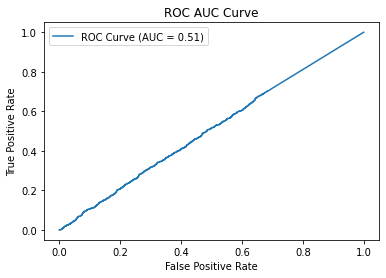

In [17]:
# Plot ROC AUC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC AUC Curve")
plt.show()

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.spatial.distance import jensenshannon

def calculate_jsd(true_data, generated_data, bins=100):
    """
    Compute the Jensen-Shannon Divergence (JSD) between the true and generated data distributions.
    
    :param true_data: Tensor or numpy array containing the true data.
    :param generated_data: Tensor or numpy array containing the generated data.
    :param bins: Number of bins to discretize the data.
    
    :return: Jensen-Shannon Divergence value.
    """
    # Flatten and convert to numpy arrays
    true_data = true_data.flatten().cpu().detach().numpy()
    generated_data = generated_data.flatten().cpu().detach().numpy()
    
    # Compute the histograms for true and generated data
    true_hist, _ = np.histogram(true_data, bins=bins, density=True)
    gen_hist, _ = np.histogram(generated_data, bins=bins, density=True)
    
    # Add a small value to avoid zero probabilities (log(0) issue)
    epsilon = 1e-8
    true_hist = np.clip(true_hist, epsilon, 1.0)
    gen_hist = np.clip(gen_hist, epsilon, 1.0)
    
    # Normalize histograms to ensure they sum to 1
    true_hist /= true_hist.sum()
    gen_hist /= gen_hist.sum()
    
    # Compute the Jensen-Shannon Divergence
    jsd = jensenshannon(true_hist, gen_hist)
    
    return jsd

# Example usage
if __name__ == "__main__":
    # Simulate some data for testing
    true_data = torch.randn(1000)  # Example true data (e.g., real samples)
    generated_data = torch.randn(1000)  # Example generated data (e.g., fake samples)
    
    jsd_score = calculate_jsd(true_data, generated_data, bins=100)
    print(f"Jensen-Shannon Divergence (Mode Collapse Score): {jsd_score:.4f}")


/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Jensen-Shannon Divergence (Mode Collapse Score): 0.1876
